In [1]:
grid_file = '/home/benr/src/ssm-analysis/SSM_Grid/ssm_grid.2dm'

import configparser
import re
import os

from netCDF4 import Dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from fvcom import FvcomGrid, Transect, ControlVolume

In [2]:
data = Dataset('results/npp.nc')
data

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    model_start: 2014-01-01 00:00:00
    dimensions(sizes): time(4380), node(3137), nele(4129)
    variables(dimensions): int32 node(node), float32 h(node), float32 x(node), float32 y(node), int32 nele(nele), float32 time(time), float32 controltotal_netPP(time, node), float32 c2936total_netPP(time, node), float32 q1c454total_netPP(time, node), float32 q1c10total_netPP(time, node), float32 q1c15total_netPP(time, node), float32 q1c20total_netPP(time, node), float32 q1c25total_netPP(time, node), float32 q1c2936total_netPP(time, node), float32 q3c454total_netPP(time, node), float32 q3c10total_netPP(time, node), float32 q3c15total_netPP(time, node), float32 q3c20total_netPP(time, node), float32 q3c25total_netPP(time, node), float32 q3c2936total_netPP(time, node), float32 q5c454total_netPP(time, node), float32 q5c10total_netPP(time, node), float32 q5c15total_netPP(time, node), float32 q5c20total_netPP(time,

In [3]:
def sort(vs):
    r = re.compile('q([1-9])c([0-9]+)')
    dec = []
    for v in vs:
        if v[-11:] != 'total_netPP':
            continue
        n = v[:-11] # Remove 'total_netPP'
        m = r.match(n)
        if m:
            q = m.group(1)
            c = m.group(2)
            if c == '454':
                c = '0' + c
        else:
            if n == 'control':
                q = '0'
                c = '0'
            else:
                q = '0'
                c = '1'
        dec.append((q, c, n))
    dec.sort()
    return [n for q, c, n in dec]

sort(data.variables)

['control',
 'c2936',
 'q1c454',
 'q1c10',
 'q1c15',
 'q1c20',
 'q1c25',
 'q1c2936',
 'q3c454',
 'q3c10',
 'q3c15',
 'q3c20',
 'q3c25',
 'q3c2936',
 'q5c454',
 'q5c10',
 'q5c15',
 'q5c20',
 'q5c25',
 'q5c2936',
 'q7c454',
 'q7c10',
 'q7c15',
 'q7c20',
 'q7c25',
 'q7c2936',
 'q9c454',
 'q9c10',
 'q9c15',
 'q9c20',
 'q9c25',
 'q9c2936']

In [4]:
grid = FvcomGrid.from_mesh(grid_file)
areas = grid.tces_gdf().loc[data['node'][:]].area
areas

4478     1.290208e+06
4479     1.012244e+06
4480     1.511056e+06
4481     1.856297e+06
4482     1.190541e+06
             ...     
15989    2.452663e+05
15993    2.198963e+05
15994    1.809223e+05
16000    9.728483e+04
16003    2.510567e+05
Length: 3137, dtype: float64

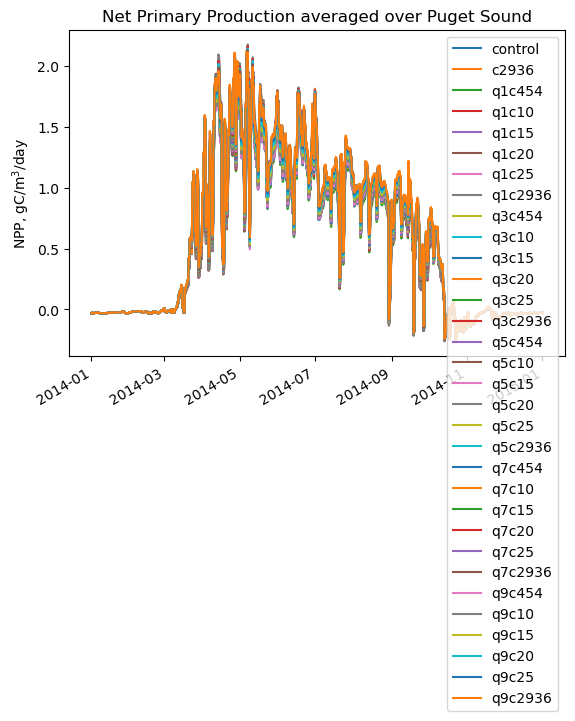

In [5]:
dates = pd.Timestamp(data.model_start) + pd.to_timedelta(data['time'][:], 'D')
fig, ax = plt.subplots()
npp_avgs = {}
for name in sort(data.variables):
    ser = pd.Series(np.average(data[name + 'total_netPP'][:], axis=1, weights=areas), index=dates)
    ser.rolling('1D').mean().plot(ax=ax, label=name)
    npp_avgs[name] = ser
npp_avgs_df = pd.DataFrame(npp_avgs)
ax.set_title('Net Primary Production averaged over Puget Sound')
ax.set_ylabel('NPP, gC/m$^3$/day')
ax.legend()

In [6]:
npp_avgs_df.to_excel('results/puget_sound/npp_avg_gcm-3d-1.xlsx')

In [7]:
sections_file = 'inlet_sections_aurora.ini'
sections_config = configparser.ConfigParser()
sections_config.read(sections_file)

# names of sections that bound each control volume
cv_bounds = {
    'Penn Cove': ['PennCove'],
    'Holmes Harbor': ['HolmesHbr'],
    'Crescent Bay': ['CrescentBy'],
    'Carr Inlet': ['CarrInl'],
    'Case Inlet': ['CaseInl'],
    'Elliot Bay': ['ElliotBy'],
    'Commencement Bay': ['CommenceBy'],
    'Dabob Bay': ['DabobBy'],
    'Port Susan': ['PtSusan','StillaguamishSouthFork','StillaguamishPassSouth'],
    'Dyes Inlet': ['DyesInl'],
    'Sinclair Inlet': ['SinclairInl'],
    'Quartermaster Harbor': ['QtrHbr'],
    'Lynch Cove': ['LynchCove']
}

In [8]:
dirname = lambda n: n.lower().replace(' ', '_')

cvs = {}
for name, sectnames in cv_bounds.items():
    transects = []
    display(name)
    for sn in sectnames:
        waypoints = np.array(sections_config[sn]['waypoints'].split(' ')).astype(int)
        t = Transect.shortest(grid, waypoints)
        transects.append(t)
    cvs[name] = ControlVolume.from_transects(transects, calc=True)
    if not os.path.isdir(f'results/{dirname(name)}'):
        os.mkdir(f'results/{dirname(name)}')
    display(len(cvs[name].nodes))

'Penn Cove'

14

'Holmes Harbor'

26

'Crescent Bay'

10

'Carr Inlet'

157

'Case Inlet'

100

'Elliot Bay'

166

'Commencement Bay'

60

'Dabob Bay'

104

'Port Susan'

190

'Dyes Inlet'

42

'Sinclair Inlet'

16

'Quartermaster Harbor'

40

'Lynch Cove'

96

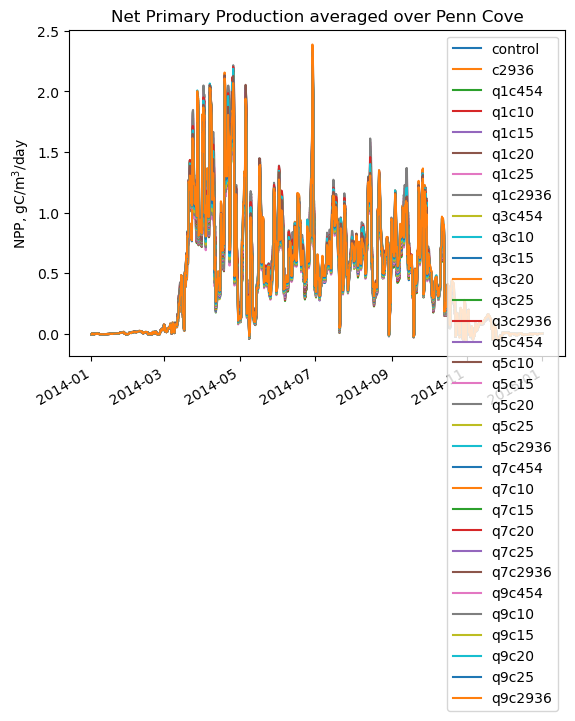

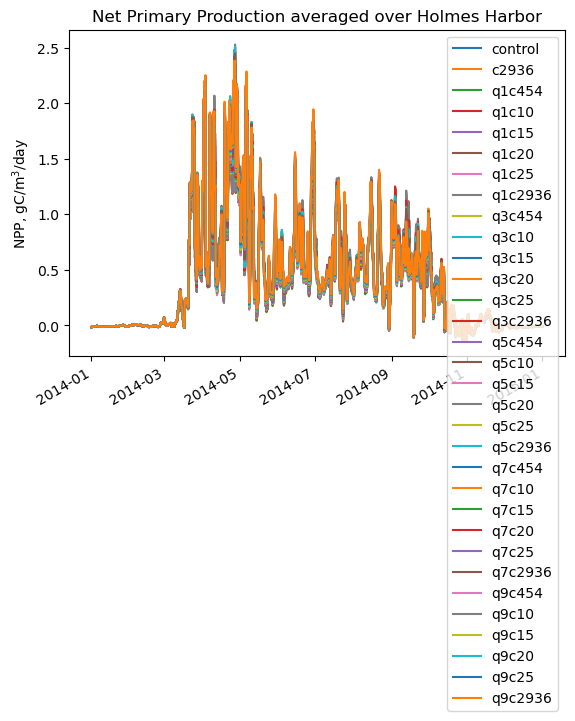

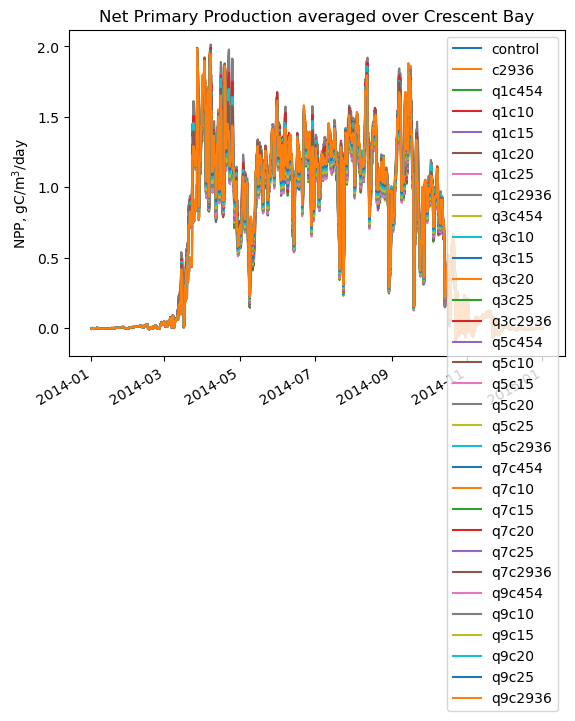

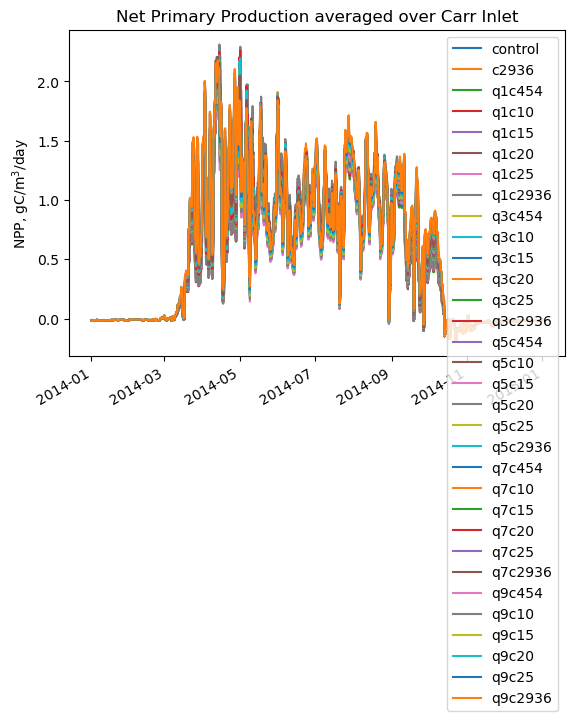

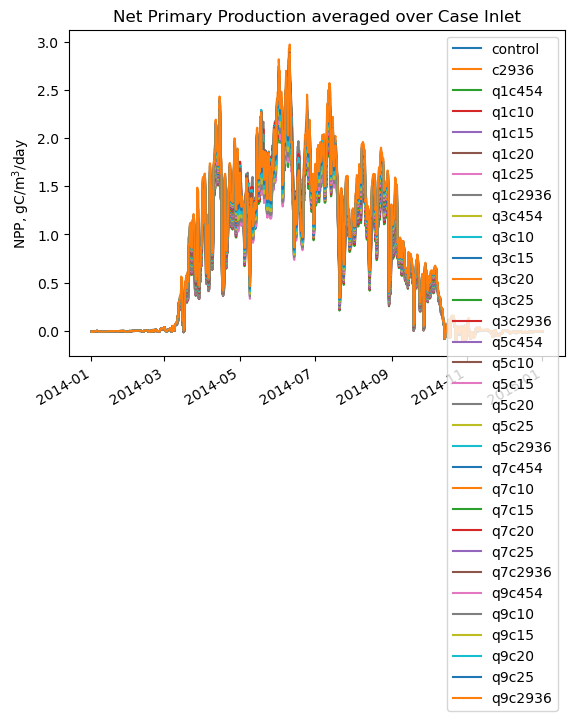

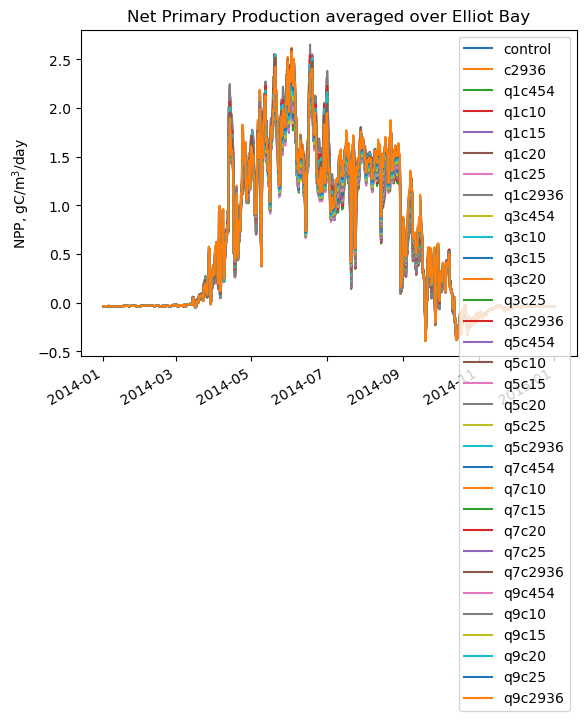

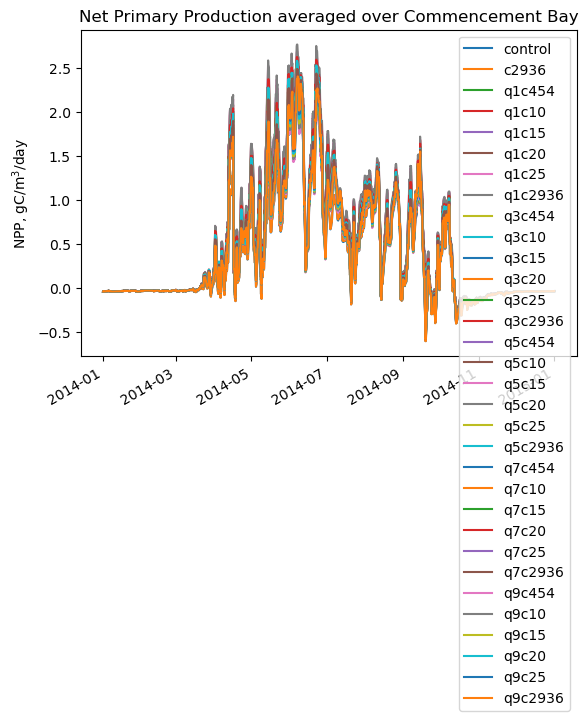

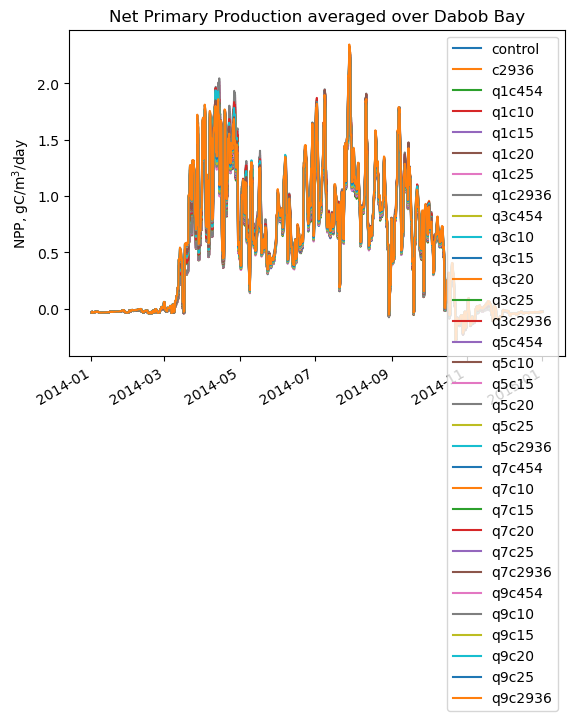

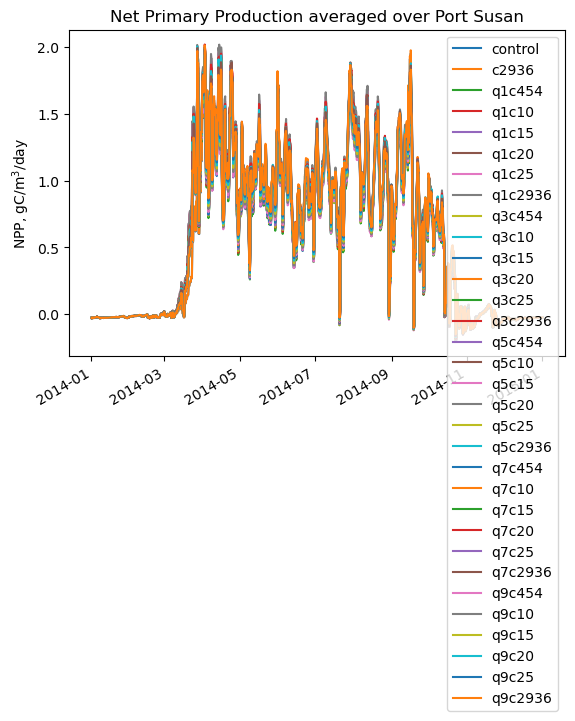

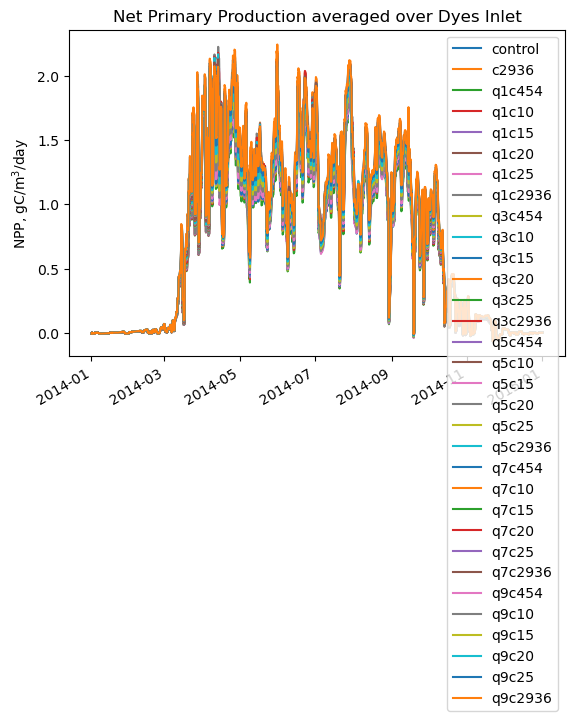

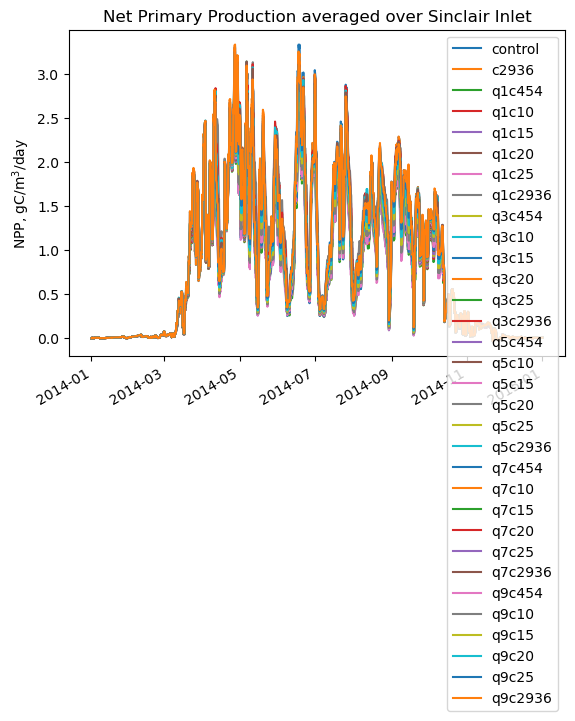

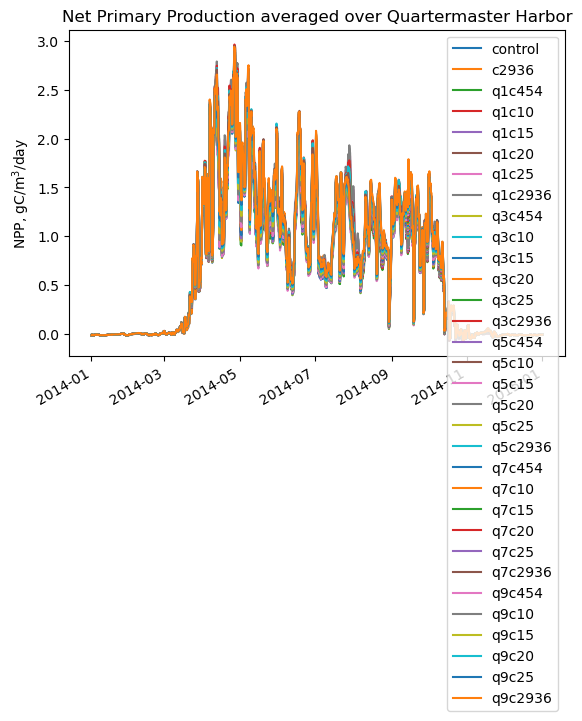

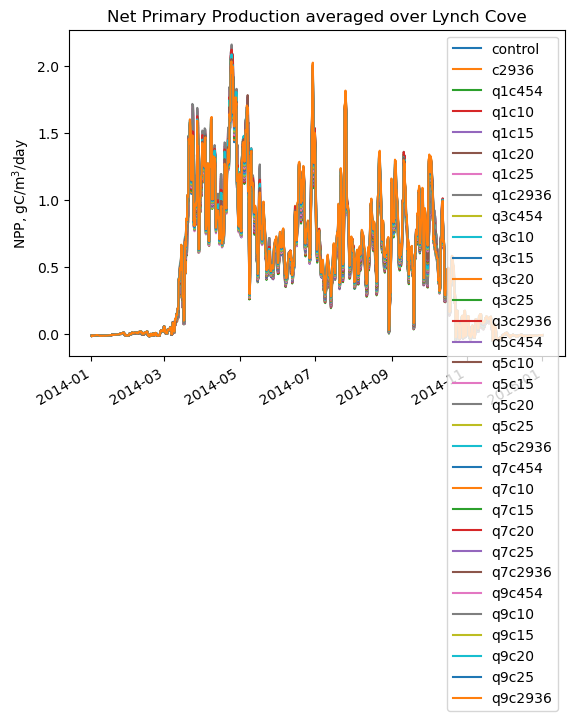

In [9]:
npp_avgs_by_cv = {}
for cvname,cv in cvs.items():
    fig, ax = plt.subplots()
    npp_avgs = {}
    idxs = np.searchsorted(data['node'][:], np.array(list(cv.nodes & set(data['node'][:]))))
    for name in sort(data.variables):
        ser = pd.Series(np.average(data[name + 'total_netPP'][:,idxs], axis=1, weights=areas.iloc[idxs]), index=dates)
        ser.rolling('1D').mean().plot(ax=ax, label=name)
        npp_avgs[name + 'total_netPP'] = ser
    npp_avgs_by_cv[cvname] = pd.DataFrame(npp_avgs)
    ax.set_title(f'Net Primary Production averaged over {cvname}')
    ax.set_ylabel('NPP, gC/m$^3$/day')
    ax.legend()

In [10]:
for name,df in npp_avgs_by_cv.items():
    display(name)
    display(df.mean())
    df.to_excel(f'results/{dirname(name)}/npp_avg_gcm-3d-1.xlsx')

'Penn Cove'

controltotal_netPP    0.452893
c2936total_netPP      0.458227
q1c454total_netPP     0.431379
q1c10total_netPP      0.441353
q1c15total_netPP      0.450622
q1c20total_netPP      0.459855
q1c25total_netPP      0.469114
q1c2936total_netPP    0.477144
q3c454total_netPP     0.430046
q3c10total_netPP      0.439440
q3c15total_netPP      0.448237
q3c20total_netPP      0.457055
q3c25total_netPP      0.465901
q3c2936total_netPP    0.473599
q5c454total_netPP     0.428840
q5c10total_netPP      0.438037
q5c15total_netPP      0.446679
q5c20total_netPP      0.455350
q5c25total_netPP      0.464071
q5c2936total_netPP    0.471672
q7c454total_netPP     0.425032
q7c10total_netPP      0.433878
q7c15total_netPP      0.442225
q7c20total_netPP      0.450638
q7c25total_netPP      0.459080
q7c2936total_netPP    0.465694
q9c454total_netPP     0.418300
q9c10total_netPP      0.426658
q9c15total_netPP      0.434538
q9c20total_netPP      0.442532
q9c25total_netPP      0.450590
q9c2936total_netPP    0.457624
dtype: f

'Holmes Harbor'

controltotal_netPP    0.421087
c2936total_netPP      0.426224
q1c454total_netPP     0.378491
q1c10total_netPP      0.387133
q1c15total_netPP      0.395167
q1c20total_netPP      0.403178
q1c25total_netPP      0.411210
q1c2936total_netPP    0.418203
q3c454total_netPP     0.384915
q3c10total_netPP      0.393276
q3c15total_netPP      0.401056
q3c20total_netPP      0.408864
q3c25total_netPP      0.416714
q3c2936total_netPP    0.423562
q5c454total_netPP     0.385722
q5c10total_netPP      0.393926
q5c15total_netPP      0.401600
q5c20total_netPP      0.409296
q5c25total_netPP      0.417044
q5c2936total_netPP    0.423818
q7c454total_netPP     0.387911
q7c10total_netPP      0.396013
q7c15total_netPP      0.403627
q7c20total_netPP      0.411284
q7c25total_netPP      0.418957
q7c2936total_netPP    0.424970
q9c454total_netPP     0.391349
q9c10total_netPP      0.399263
q9c15total_netPP      0.406677
q9c20total_netPP      0.414172
q9c25total_netPP      0.421709
q9c2936total_netPP    0.428284
dtype: f

'Crescent Bay'

controltotal_netPP    0.652748
c2936total_netPP      0.661378
q1c454total_netPP     0.620210
q1c10total_netPP      0.634613
q1c15total_netPP      0.648188
q1c20total_netPP      0.661844
q1c25total_netPP      0.675620
q1c2936total_netPP    0.687624
q3c454total_netPP     0.616523
q3c10total_netPP      0.629989
q3c15total_netPP      0.642753
q3c20total_netPP      0.655691
q3c25total_netPP      0.668779
q3c2936total_netPP    0.680224
q5c454total_netPP     0.613611
q5c10total_netPP      0.626730
q5c15total_netPP      0.639221
q5c20total_netPP      0.651885
q5c25total_netPP      0.664708
q5c2936total_netPP    0.675933
q7c454total_netPP     0.611029
q7c10total_netPP      0.623695
q7c15total_netPP      0.635797
q7c20total_netPP      0.648128
q7c25total_netPP      0.660581
q7c2936total_netPP    0.670396
q9c454total_netPP     0.606730
q9c10total_netPP      0.618731
q9c15total_netPP      0.630141
q9c20total_netPP      0.641841
q9c25total_netPP      0.653723
q9c2936total_netPP    0.664148
dtype: f

'Carr Inlet'

controltotal_netPP    0.556493
c2936total_netPP      0.568460
q1c454total_netPP     0.480706
q1c10total_netPP      0.494832
q1c15total_netPP      0.507960
q1c20total_netPP      0.521058
q1c25total_netPP      0.534205
q1c2936total_netPP    0.545655
q3c454total_netPP     0.490092
q3c10total_netPP      0.503994
q3c15total_netPP      0.517002
q3c20total_netPP      0.530053
q3c25total_netPP      0.543142
q3c2936total_netPP    0.554535
q5c454total_netPP     0.492758
q5c10total_netPP      0.506556
q5c15total_netPP      0.519527
q5c20total_netPP      0.532515
q5c25total_netPP      0.545595
q5c2936total_netPP    0.556995
q7c454total_netPP     0.496218
q7c10total_netPP      0.509967
q7c15total_netPP      0.522897
q7c20total_netPP      0.535899
q7c25total_netPP      0.548922
q7c2936total_netPP    0.558849
q9c454total_netPP     0.502201
q9c10total_netPP      0.515805
q9c15total_netPP      0.528558
q9c20total_netPP      0.541461
q9c25total_netPP      0.554431
q9c2936total_netPP    0.565716
dtype: f

'Case Inlet'

controltotal_netPP    0.755536
c2936total_netPP      0.772661
q1c454total_netPP     0.618500
q1c10total_netPP      0.634742
q1c15total_netPP      0.649688
q1c20total_netPP      0.664471
q1c25total_netPP      0.679193
q1c2936total_netPP    0.691918
q3c454total_netPP     0.650683
q3c10total_netPP      0.666641
q3c15total_netPP      0.681424
q3c20total_netPP      0.696133
q3c25total_netPP      0.710758
q3c2936total_netPP    0.723394
q5c454total_netPP     0.659694
q5c10total_netPP      0.675529
q5c15total_netPP      0.690255
q5c20total_netPP      0.704897
q5c25total_netPP      0.719518
q5c2936total_netPP    0.732169
q7c454total_netPP     0.670536
q7c10total_netPP      0.686310
q7c15total_netPP      0.700992
q7c20total_netPP      0.715632
q7c25total_netPP      0.730194
q7c2936total_netPP    0.740822
q9c454total_netPP     0.687667
q9c10total_netPP      0.703384
q9c15total_netPP      0.717982
q9c20total_netPP      0.732631
q9c25total_netPP      0.747232
q9c2936total_netPP    0.759853
dtype: f

'Elliot Bay'

controltotal_netPP    0.632843
c2936total_netPP      0.641329
q1c454total_netPP     0.551871
q1c10total_netPP      0.564669
q1c15total_netPP      0.576590
q1c20total_netPP      0.588557
q1c25total_netPP      0.600602
q1c2936total_netPP    0.611114
q3c454total_netPP     0.562696
q3c10total_netPP      0.574938
q3c15total_netPP      0.586398
q3c20total_netPP      0.597992
q3c25total_netPP      0.609681
q3c2936total_netPP    0.619887
q5c454total_netPP     0.564387
q5c10total_netPP      0.576350
q5c15total_netPP      0.587616
q5c20total_netPP      0.598998
q5c25total_netPP      0.610471
q5c2936total_netPP    0.620512
q7c454total_netPP     0.568037
q7c10total_netPP      0.579744
q7c15total_netPP      0.590784
q7c20total_netPP      0.601951
q7c25total_netPP      0.613204
q7c2936total_netPP    0.621805
q9c454total_netPP     0.571157
q9c10total_netPP      0.582285
q9c15total_netPP      0.592757
q9c20total_netPP      0.603418
q9c25total_netPP      0.614186
q9c2936total_netPP    0.623615
dtype: f

'Commencement Bay'

controltotal_netPP    0.363422
c2936total_netPP      0.368732
q1c454total_netPP     0.467612
q1c10total_netPP      0.482421
q1c15total_netPP      0.495055
q1c20total_netPP      0.506993
q1c25total_netPP      0.518402
q1c2936total_netPP    0.527937
q3c454total_netPP     0.432753
q3c10total_netPP      0.444431
q3c15total_netPP      0.454461
q3c20total_netPP      0.463983
q3c25total_netPP      0.473093
q3c2936total_netPP    0.480657
q5c454total_netPP     0.418611
q5c10total_netPP      0.429299
q5c15total_netPP      0.438540
q5c20total_netPP      0.447308
q5c25total_netPP      0.455652
q5c2936total_netPP    0.462603
q7c454total_netPP     0.399784
q7c10total_netPP      0.409260
q7c15total_netPP      0.417432
q7c20total_netPP      0.425222
q7c25total_netPP      0.432656
q7c2936total_netPP    0.438361
q9c454total_netPP     0.369381
q9c10total_netPP      0.377197
q9c15total_netPP      0.383980
q9c20total_netPP      0.390498
q9c25total_netPP      0.396799
q9c2936total_netPP    0.402105
dtype: f

'Dabob Bay'

controltotal_netPP    0.533454
c2936total_netPP      0.536700
q1c454total_netPP     0.499808
q1c10total_netPP      0.507099
q1c15total_netPP      0.513843
q1c20total_netPP      0.520467
q1c25total_netPP      0.527101
q1c2936total_netPP    0.532850
q3c454total_netPP     0.504931
q3c10total_netPP      0.511829
q3c15total_netPP      0.518243
q3c20total_netPP      0.524616
q3c25total_netPP      0.530975
q3c2936total_netPP    0.536507
q5c454total_netPP     0.504973
q5c10total_netPP      0.511705
q5c15total_netPP      0.518002
q5c20total_netPP      0.524224
q5c25total_netPP      0.530464
q5c2936total_netPP    0.535898
q7c454total_netPP     0.507215
q7c10total_netPP      0.513770
q7c15total_netPP      0.519932
q7c20total_netPP      0.526046
q7c25total_netPP      0.532166
q7c2936total_netPP    0.536493
q9c454total_netPP     0.510790
q9c10total_netPP      0.517052
q9c15total_netPP      0.522915
q9c20total_netPP      0.528803
q9c25total_netPP      0.534712
q9c2936total_netPP    0.539855
dtype: f

'Port Susan'

controltotal_netPP    0.574309
c2936total_netPP      0.582400
q1c454total_netPP     0.540801
q1c10total_netPP      0.555405
q1c15total_netPP      0.569036
q1c20total_netPP      0.582685
q1c25total_netPP      0.596440
q1c2936total_netPP    0.608447
q3c454total_netPP     0.539556
q3c10total_netPP      0.553294
q3c15total_netPP      0.566151
q3c20total_netPP      0.579114
q3c25total_netPP      0.592170
q3c2936total_netPP    0.603584
q5c454total_netPP     0.538037
q5c10total_netPP      0.551443
q5c15total_netPP      0.564070
q5c20total_netPP      0.576783
q5c25total_netPP      0.589598
q5c2936total_netPP    0.600812
q7c454total_netPP     0.537078
q7c10total_netPP      0.550082
q7c15total_netPP      0.562337
q7c20total_netPP      0.574723
q7c25total_netPP      0.587171
q7c2936total_netPP    0.596937
q9c454total_netPP     0.533091
q9c10total_netPP      0.545388
q9c15total_netPP      0.556953
q9c20total_netPP      0.568690
q9c25total_netPP      0.580531
q9c2936total_netPP    0.590896
dtype: f

'Dyes Inlet'

controltotal_netPP    0.773068
c2936total_netPP      0.785599
q1c454total_netPP     0.642358
q1c10total_netPP      0.663336
q1c15total_netPP      0.682752
q1c20total_netPP      0.702134
q1c25total_netPP      0.721492
q1c2936total_netPP    0.738206
q3c454total_netPP     0.661725
q3c10total_netPP      0.682291
q3c15total_netPP      0.701363
q3c20total_netPP      0.720447
q3c25total_netPP      0.739531
q3c2936total_netPP    0.756053
q5c454total_netPP     0.667321
q5c10total_netPP      0.687758
q5c15total_netPP      0.706764
q5c20total_netPP      0.725774
q5c25total_netPP      0.744773
q5c2936total_netPP    0.761242
q7c454total_netPP     0.673659
q7c10total_netPP      0.693973
q7c15total_netPP      0.712868
q7c20total_netPP      0.731779
q7c25total_netPP      0.750664
q7c2936total_netPP    0.766218
q9c454total_netPP     0.684483
q9c10total_netPP      0.704601
q9c15total_netPP      0.723277
q9c20total_netPP      0.742038
q9c25total_netPP      0.760781
q9c2936total_netPP    0.777007
dtype: f

'Sinclair Inlet'

controltotal_netPP    0.868999
c2936total_netPP      0.873893
q1c454total_netPP     0.710093
q1c10total_netPP      0.752728
q1c15total_netPP      0.790715
q1c20total_netPP      0.827671
q1c25total_netPP      0.863744
q1c2936total_netPP    0.894317
q3c454total_netPP     0.710059
q3c10total_netPP      0.750021
q3c15total_netPP      0.785844
q3c20total_netPP      0.820881
q3c25total_netPP      0.855271
q3c2936total_netPP    0.884412
q5c454total_netPP     0.708727
q5c10total_netPP      0.747580
q5c15total_netPP      0.782555
q5c20total_netPP      0.816792
q5c25total_netPP      0.850338
q5c2936total_netPP    0.878779
q7c454total_netPP     0.707387
q7c10total_netPP      0.745222
q7c15total_netPP      0.779223
q7c20total_netPP      0.812488
q7c25total_netPP      0.845114
q7c2936total_netPP    0.871966
q9c454total_netPP     0.706690
q9c10total_netPP      0.743109
q9c15total_netPP      0.775857
q9c20total_netPP      0.808121
q9c25total_netPP      0.839750
q9c2936total_netPP    0.866671
dtype: f

'Quartermaster Harbor'

controltotal_netPP    0.696964
c2936total_netPP      0.708049
q1c454total_netPP     0.627222
q1c10total_netPP      0.646787
q1c15total_netPP      0.664888
q1c20total_netPP      0.683017
q1c25total_netPP      0.701193
q1c2936total_netPP    0.716976
q3c454total_netPP     0.634459
q3c10total_netPP      0.653666
q3c15total_netPP      0.671455
q3c20total_netPP      0.689329
q3c25total_netPP      0.707268
q3c2936total_netPP    0.722896
q5c454total_netPP     0.635960
q5c10total_netPP      0.655029
q5c15total_netPP      0.672762
q5c20total_netPP      0.690578
q5c25total_netPP      0.708473
q5c2936total_netPP    0.724078
q7c454total_netPP     0.635320
q7c10total_netPP      0.654184
q7c15total_netPP      0.671765
q7c20total_netPP      0.689444
q7c25total_netPP      0.707171
q7c2936total_netPP    0.721385
q9c454total_netPP     0.636127
q9c10total_netPP      0.654700
q9c15total_netPP      0.671942
q9c20total_netPP      0.689382
q9c25total_netPP      0.706893
q9c2936total_netPP    0.722134
dtype: f

'Lynch Cove'

controltotal_netPP    0.503739
c2936total_netPP      0.506137
q1c454total_netPP     0.469495
q1c10total_netPP      0.476139
q1c15total_netPP      0.482287
q1c20total_netPP      0.488301
q1c25total_netPP      0.494351
q1c2936total_netPP    0.499583
q3c454total_netPP     0.479371
q3c10total_netPP      0.485630
q3c15total_netPP      0.491468
q3c20total_netPP      0.497261
q3c25total_netPP      0.503065
q3c2936total_netPP    0.508124
q5c454total_netPP     0.480128
q5c10total_netPP      0.486243
q5c15total_netPP      0.491986
q5c20total_netPP      0.497651
q5c25total_netPP      0.503326
q5c2936total_netPP    0.508291
q7c454total_netPP     0.483124
q7c10total_netPP      0.489043
q7c15total_netPP      0.494622
q7c20total_netPP      0.500151
q7c25total_netPP      0.505685
q7c2936total_netPP    0.509627
q9c454total_netPP     0.491173
q9c10total_netPP      0.496906
q9c15total_netPP      0.502275
q9c20total_netPP      0.507680
q9c25total_netPP      0.513080
q9c2936total_netPP    0.517780
dtype: f